# Package Declaration

Here, we will only use numpy for numerical calculation. Other packages are used for visualisation and simplyifing the codes.

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
from tqdm import tqdm

In [173]:
def standard_plot(axis):
    axis.set_xlim(0, 5)
    axis.set_xlabel(r'$r$')
    axis.legend()

# Gauge Invariant Metropolis

Here, we construct a base class for arbitrary dimension gauge theory metropolis algorithm. Following its name, the algorithm can be used for any arbitrary spacetime dimension $D$ and any number $N$ of SU($N$) gauge group, although they can only simulate one gauge fields and does not involve any other fields. For concreteness, we are using $D=4 (3+1)$ and SU(3) gauge group. 

There are several variables that are always required for the calculations. Some are related to the physical system, while others are related to the metropolis sampling. Some variables that are fit into the first category are lattice separation $a$, coupling constant $\beta$, and number of lattice sites $N$ (such that the length of the system is $aN$), while maximum update size $\epsilon$, number of configurations generated, and some other variables fall into the second category.

## Link Metropolis update

Instead of updating gauge fields $A_{\mu}(x)$ on each lattice site $x$, we update the link $U_{\mu}$ between $x$ and $x + \hat{mu}$. Instead of increasing or decreasing the matrix components by some random number, we multiply the links with hermitian matrices $U_{\mu} \rightarrow MU_{\mu}$. Therefore, the first step is to generator random matrices and call them randomly later. This process is taken care by the following lines, which is inspired from [the following github pages](https://github.com/AlessandroCotellucci/Lattice-QCD-for-novice/blob/master/Wilson_loop.py)

```
H = np.random.uniform(-1, 1, (3, 3)) + np.random.uniform(-1, 1, (3, 3)) * (1j)
H = (H + H.conj().T) / 2
U = np.zeros((3, 3), dtype=complex)
for k in range(30):
    l = math.factorial(k)
    U += (((self.eps * (1j)) ** k) / l ) * np.linalg.matrix_power(H, k)
U /= np.linalg.det(U) ** (1/3)
```

### The action
Analytic Lagrangian for SU$(N)$ gauge theory is given by $-\frac{1}{4}F^a_{\mu\nu}F^{a\mu\nu}$, where $F_{\mu\nu}$ is a function of $A_{\mu}$. As we deals with $U_{\mu}$, we need to look for a function of $U_{\mu}$ that approximate the Lagrangian. Fortunately, this can be achieved via Wilson plaquette/loop. The simplest action can be written as

\begin{equation}
S \approx \beta\sum_x\sum_{\mu,\nu> \mu}(1 - P_{\mu\nu}(x)), ~~~P_{\mu\nu}(x) = \frac{1}{3}\Re\left[U_{\mu}(x)U_{\nu}(x + \hat{\mu}) U^{\dagger}_{\mu}(x + \hat{\nu})U^{\dagger}_{\nu}(x)\right]
\end{equation}

Exploiting the fact that $P_{\mu\nu}$ only contain matrix multiplication, we can factorise $U_{\mu}$ when computing action difference, $\Delta S_{U_\mu} = (U_{\mu} - MU_{\mu})\Gamma$. The Metropolis proposal $U_{\mu} \rightarrow MU_{\mu}$ can then be accepted or rejected depending on $\Delta S$. Different from the previous implementation, here we typically update the link variables $n_a$ times before moving into the next link. However, as we have stated before, due to $\Gamma$ completely independent of $U_{\mu}$, we only need to compute it once and perform $n_a$ proposals afterwards, preventing costly computation which happens if we compute new gamma in each update.

```
Gamma = self.gamma(U, x, x1, i)
for j in range(self.na):    
    M = self.Mlist[k[*x, i, j]]
    U_new = M @ U[*x, i]
    delta = self.b * np.trace((U[*x, i] - U_new) @ Gamma).real / 3
    p_acc = np.exp(-delta)
    
    if draw[*x, i, j] < p_acc:
        U[*x, i] = U_new
```

In the codes above, the computation of $\Gamma$ is taken care by function ```gamma```. By continuing until all links have been visited, we have completed exactly one update.

## Running the algorithm

We start the run by proposing a trivial configurations, $\{U_{\mu}(x)\} = \{I\}$, i.e. identity matrices. To avoid correlation between configurations, we discard $n_{corr}$ of configurations before accepting the next one. A special case is in the beginning of the metropolis algorithm, where we wait until the configurations has been "thermalised" by discarding $n_{update} * n_{corr}$ configurations. These are depicted in the following lines

## Computing the observables

The interesting observables we can compute from the lattice calculation are the Wilson loops. For now, we will compute $a\times a$ and $a \times 2 a$ Wilson loops. This is taken care by function ```loops```. The loops over all sites are then averaged, producing averaged Wilson loops.

In [130]:
class Metrogluon:
    #Metropolis algorithm base class
    def __init__(self, size = 0.25, beta = 5.5, u00 = 1, eps = 0.24, 
                 num_latt = 8, num_conf = 10, num_corr = 50, num_updt = 10, 
                 num_swee = 2, num_matr = 100, num_dime = 4):
        self.a = size
        self.b = beta
        self.u = u00
        self.eps = eps
        self.N = num_latt
        self.Ncf = num_conf
        self.Ncr = num_corr
        self.na  = num_updt
        self.nb  = num_swee
        self.Nma = num_matr
        self.dim = num_dime
        
        self.accepted = 0
        self.proposal = 0
    

    def randomatrix(self):
        print("Generating Random Matrices")
        Mlist = []
        for i in tqdm(range(self.Nma)):
            H = np.random.uniform(-1, 1, (3, 3)) + np.random.uniform(-1, 1, (3, 3)) * (1j)
            H = (H + H.conj().T) / 2
            U = np.zeros((3, 3), dtype=complex)
            for k in range(30):
                l = math.factorial(k)
                U += (((self.eps * (1j)) ** k) / l ) * np.linalg.matrix_power(H, k)
            U /= np.linalg.det(U) ** (1/3)
            Mlist.append(U)
            Mlist.append(U.conj().T)

        self.Mlist = Mlist 

    def gamma(self, U, x, x1, i):
        Gamma = 0
        for j in range(self.dim):
            if j != i:
                x2 = list(x); x2[j] = (x2[j] + 1) % self.N
                x3 = list(x); x3[i] = (x3[i] + 1) % self.N; x3[j] = (x3[j] - 1)
                x4 = list(x); x4[j] = (x4[j] - 1)
                Gamma += U[*x1, j] @ U[*x2, i].conj().T @ U[*x, j].conj().T
                Gamma += U[*x3, j].conj().T @ U[*x4, i].conj().T @ U[*x4, j]
        
        return Gamma
    
    def update(self, U):
        k = np.random.randint(0, 2 * self.Nma, (*([self.N] * self.dim), self.dim, self.na))
        draw = np.random.uniform(0, 1, (*([self.N] * self.dim), self.dim, self.na))
        for x in itertools.product(*([range(self.N)] * self.dim)):
            for i in range(self.dim):
                x1 = list(x)
                x1[i] = (x1[i] + 1) % self.N
                Gamma = self.gamma(U, x, x1, i)
                for j in range(self.na):    
                    M = self.Mlist[k[*x, i, j]]
                    U_new = M @ U[*x, i]
                    delta = self.b * np.trace((U[*x, i] - U_new) @ Gamma).real / 3
                    p_acc = np.exp(-delta)
                    
                    if draw[*x, i, j] < p_acc:
                        U[*x, i] = U_new
                        self.accepted += 1
                    self.proposal += 1
        return U
    
    def loops(self, U, x, x1, i):
        ax1a = 0
        ax2a = 0
        for j in range(i + 1, self.dim):
            x2, x3, x4 = list(x), list(x), list(x)
            x2[j] = (x2[j] + 1) % self.N
            x3[i] = (x3[i] + 1) % self.N
            x3[j] = (x3[j] + 1) % self.N
            x4[j] = (x4[j] + 2) % self.N
            A1A = U[*x, i] @ U[*x1, j] @ U[*x2, i].conj().T @ U[*x, j].conj().T
            A2A = U[*x, i] @ U[*x1, j] @ U[*x3, j] @ U[*x4, i].conj().T @ U[*x2, j].conj().T @ U[*x, j].conj().T
            ax1a += np.trace(A1A).real / 3
            ax2a += np.trace(A2A).real / 3
        return ax1a, ax2a

    def run_actual(self):

        self.randomatrix()

        U = np.zeros((*([self.N] * self.dim), self.dim, 3,3), dtype=complex)
        for coords in tqdm(itertools.product(*([range(self.N)] * self.dim))):
            for i in range(self.dim):
                for j in range(3):
                    U[*coords, i, j, j] = 1

        print("Thermalising Initial Lattice")
        for i in tqdm(range(self.nb * self.Ncr)):
            U = self.update(U)

        AX1A, AX2A, cfgs = [], [], []
        for i in tqdm(range(self.Ncf)):
            for j in range(self.Ncr):
                U = self.update(U)
    
            ax1a, ax2a = 0, 0
            for x in itertools.product(*([range(self.N)] * self.dim)):
                for k in range(self.dim):
                    x1 = list(x)
                    x1[k] = (x1[k] + 1) % self.N
                    a, b = self.loops(U, x, x1, k)
                    ax1a += a
                    ax2a += b

            AX1A.append(ax1a / ((self.N ** self.dim) * (self.dim - 1) * self.dim / 2))
            AX2A.append(ax2a / ((self.N ** self.dim) * (self.dim - 1) * self.dim / 2))
            cfgs.append(U.copy())
            

        self.AX1A = AX1A
        self.AX2A = AX2A
        self.cfgs = cfgs

        return np.average(np.array(AX1A)), np.average(np.array(AX2A)), cfgs[-1]

In [131]:
Base = Metrogluon(num_conf = 10, num_latt = 8, num_dime = 4)
ax1a, ax2a, U = Base.run_actual()

Generating Random Matrices


100%|██████████| 100/100 [00:00<00:00, 1024.69it/s]
4096it [00:00, 149513.68it/s]


Thermalising Initial Lattice


100%|██████████| 10/10 [22:27<00:00, 134.76s/it]


Using the parameters provided in the lecture notes, we have run the metropolis algorithm and obtain the following values of Wilson loops

In [132]:
AA1 = np.array(Base.AX1A)
AA2 = np.array(Base.AX2A)

print(AA1)
print(AA2)
print(f'average for axa  = {np.average(AA1):.3f} ({np.std(AA1):.3f})')
print(f'average for ax2a = {np.average(AA2):.3f} ({np.std(AA2):.3f})')

[0.50363183 0.49724293 0.49414296 0.49637212 0.49531332 0.49957464
 0.49536606 0.49859411 0.4938333  0.49265049]
[0.266933   0.25937974 0.25814408 0.2581106  0.2579821  0.26293245
 0.25725859 0.2594482  0.25439538 0.25138605]
average for axa  = 0.497 (0.003)
average for ax2a = 0.259 (0.004)


## Improved action

Just like the case with QM Metropolis, we can also improve the accuracy of the calculation by adding higher order terms to the action. In this case, we add $a\times 2a$ Wilson plaquette into the action, resulting in

\begin{equation}
S \approx -\beta \sum_x\sum_{\mu, \nu> \mu}\left[\frac{5}{3}P_{\mu\nu} - \frac{R_{\mu\nu} + R_{\nu\mu}}{12}\right]
\end{equation}

In [133]:
class Metrogluon_imp(Metrogluon):
    def __init__(self, *args, 
                 mode = 'unimproved',
                 bbar = 1.719,
                 u00b = 0.797,
                 **kwargs):
        super().__init__(*args, **kwargs)
        self.mode = mode
        self.bb   = bbar
        self.uu   = u00b
    
    def gamma(self, U, x, x1, i):
        Gamma = 0
        for j in range(self.dim):
            if j != i:
                x2 = list(x); x2[j] = (x2[j] + 1) % self.N
                x3 = list(x); x3[i] = (x3[i] + 1) % self.N; x3[j] = (x3[j] - 1) % self.N  
                x4 = list(x); x4[j] = (x4[j] - 1) % self.N
                Gamma += U[*x1, j] @ U[*x2, i].conj().T @ U[*x, j].conj().T
                Gamma += U[*x3, j].conj().T @ U[*x4, i].conj().T @ U[*x4, j]
        
        if self.mode == 'improved':
            Gamma_imp = 0
            for j in range(self.dim):
                if j != i:
                    x2 = list(x); x2[i] = (x2[i] + 2) % self.N
                    x3 = list(x); x3[i] = (x3[i] + 1) % self.N; x3[j] = (x3[j] + 1) % self.N
                    x4 = list(x); x4[j] = (x4[j] + 1) % self.N
                    x5 = list(x); x5[i] = (x5[i] + 2) % self.N; x5[j] = (x5[j] - 1) % self.N
                    x6 = list(x); x6[i] = (x6[i] + 1) % self.N; x6[j] = (x6[j] - 1) % self.N 
                    x7 = list(x); x7[j] = (x7[j] - 1) % self.N
                    x8 = list(x); x8[j] = (x8[j] + 2) % self.N
                    x9 = list(x); x9[i] = (x9[i] + 1) % self.N; x9[j] = (x9[j] - 2) % self.N
                    x10= list(x); x10[j]= (x10[j]- 2) % self.N
                    x11= list(x); x11[i]= (x11[i]- 1) % self.N; x11[j]= (x11[j]+ 1) % self.N
                    x12= list(x); x12[i]= (x12[i]- 1) % self.N
                    x13= list(x); x13[i]= (x13[i]- 1) % self.N; x13[j]= (x13[j]- 1) % self.N
                    Gamma_imp += U[*x1, i]          @ U[*x2, j]          @ U[*x3, i].conj().T @ U[*x4, i].conj().T @ U[*x , j].conj().T
                    Gamma_imp += U[*x1, i]          @ U[*x5, j].conj().T @ U[*x6, i].conj().T @ U[*x7, i].conj().T @ U[*x7, j]
                    Gamma_imp += U[*x1, j]          @ U[*x3, j]          @ U[*x8, i].conj().T @ U[*x4, j].conj().T @ U[*x , j].conj().T
                    Gamma_imp += U[*x6, j].conj().T @ U[*x9, j].conj().T @ U[*x10,i].conj().T @ U[*x10,j]          @ U[*x7, j]
                    Gamma_imp += U[*x1, j]          @ U[*x4, i].conj().T @ U[*x11,i].conj().T @ U[*x12,j].conj().T @ U[*x12,i]
                    Gamma_imp += U[*x6, j].conj().T @ U[*x7, i].conj().T @ U[*x13,i].conj().T @ U[*x13,j]          @ U[*x12,i]
            return (20 * Gamma - Gamma_imp / (self.uu**2)) * self.bb / (12 * self.b * self.uu**4)
            
        else:
            return Gamma

In [134]:
Base_imp = Metrogluon_imp(num_conf = 10, num_latt = 8, num_dime = 4, mode='improved')
ax1a_imp, ax2a_imp, U_imp = Base_imp.run_actual()

Generating Random Matrices


100%|██████████| 100/100 [00:00<00:00, 1696.83it/s]
4096it [00:00, 185587.87it/s]


Thermalising Initial Lattice


100%|██████████| 10/10 [1:26:47<00:00, 520.75s/it]


Here are the result of Wilson loops for improved action

In [135]:
AA1_imp = np.array(Base_imp.AX1A)
AA2_imp = np.array(Base_imp.AX2A)
print(AA1_imp)
print(AA2_imp)
print(f'average axa  improved = {np.average(AA1_imp):.3f} ({np.std(AA1_imp):.3f})')
print(f'average ax2a improved = {np.average(AA2_imp):.3f} ({np.std(AA2_imp):.3f})')

[0.54296733 0.54365658 0.54326071 0.53889812 0.53772731 0.53920642
 0.53591994 0.53966881 0.53888816 0.54264986]
[0.28692891 0.28879336 0.28699993 0.28071197 0.27897055 0.281196
 0.27495026 0.28218839 0.27990347 0.28497175]
average axa  improved = 0.540 (0.003)
average ax2a improved = 0.283 (0.004)


# Static Quark Potential

Other observables that can be computed are the static quark potential, which satisfies

\begin{equation}
a V(r) = \lim_{t \rightarrow \infty} W(r, t) / W(r, t + a)
\end{equation}

Here $r$ and $t$ are the size of the loops in the spatial and temporal dimension. To implement the calculation, we calculate the loops with fixed time-step and space-step, and then average over the three spatial directions for all sites.

```
for x in itertools.product(*([range(N)] * dim)):
    a, b = loop_one_two(U, x, dim - 1, k)
    loop_one += a
    loop_two += b
```

This fixes the temporal direction $\mu = 3$, while the function ```loop_one_two``` iterate over the spatial direction $\nu = 0, 1, 2$

```
for j in range(0, dim - 1):
    A = [] 
    B = []
```

Ideally, we should compute the loops for different time-step $t$ and as $t$ grows bigger, take the asymptotic value. However, here, we show only the computation for $t = a$. More options will be explored in the future. 

In [136]:
dim, N = 4, 8

def one_two(U, x, k, i, j):
    x1 = list(x); x1[j] = (x1[j] + k) % N
    x2 = list(x); x2[j] = (x2[j] + k) % N; x2[i] = (x2[i] + 1) % N
    return U[*x1, i].conj().T, U[*x2, i].conj().T @ U[*x1, i].conj().T

def loop_one_two(U, x, i, k):
    loops_one = np.zeros(k)
    loops_two = np.zeros(k)
    for j in range(0, dim - 1):
        A = [] 
        B = []

        for l in range(k):
            xr = list(x); xr[j] = (xr[j] + k - 1 - l) % N; xr[i] = (xr[i] + 1) % N
            xR = list(x); xR[j] = (xR[j] + k - 1 - l) % N; xR[i] = (xR[i] + 2) % N
            xl = list(x); xl[j] = (xl[j] + k - 1 - l) % N
            a, b = one_two(U, x, k - l, i, j) 
            A.append(a)
            B.append(b)
            A = [U[*xr, j] @ a @ U[*xl, j].conj().T for a in A]
            B = [U[*xR, j] @ b @ U[*xl, j].conj().T for b in B]

        aa, bb = one_two(U, x, 0, i, j) 
        A = np.array([np.trace(aa.conj().T @ a).real / 3 for a in A])
        B = np.array([np.trace(bb.conj().T @ b).real / 3 for b in B])
        loops_one += A
        loops_two += B
    return loops_one / 3, loops_two / 3 

In [159]:
k = 4
def static_potential(Us):
    loops_one = []
    loops_two = []
    for U in Us:
        loop_one = 0
        loop_two = 0
        for x in itertools.product(*([range(N)] * dim)):
            a, b = loop_one_two(U, x, dim - 1, k)
            loop_one += a
            loop_two += b
        loop_one /= (N ** dim)
        loop_two /= (N ** dim)
        loops_one.append(loop_one)
        loops_two.append(loop_two)
    return np.array(loops_one), np.array(loops_two)

In [160]:
ones_ori, twos_ori = static_potential(Base.cfgs)
ones_imp, twos_imp = static_potential(Base_imp.cfgs)
potential_original = ones_ori / twos_ori
potential_improved = ones_imp / twos_imp

ori_mean_std = np.array([[a, b] for a, b in zip(potential_original.mean(axis=0)[::-1], potential_original.std(axis=0)[::-1])])
imp_mean_std = np.array([[a, b] for a, b in zip(potential_improved.mean(axis=0)[::-1], potential_improved.std(axis=0)[::-1])])

print([f'{a:.4f} ({b:.4f})' for a, b in ori_mean_std])
print([f'{a:.4f} ({b:.4f})' for a, b in imp_mean_std])

['1.9240 (0.0222)', '3.3471 (0.0581)', '5.8592 (0.7031)', '9.4042 (2.4335)']
['1.9091 (0.0245)', '3.5072 (0.1679)', '6.1418 (0.6307)', '11.2648 (3.5473)']


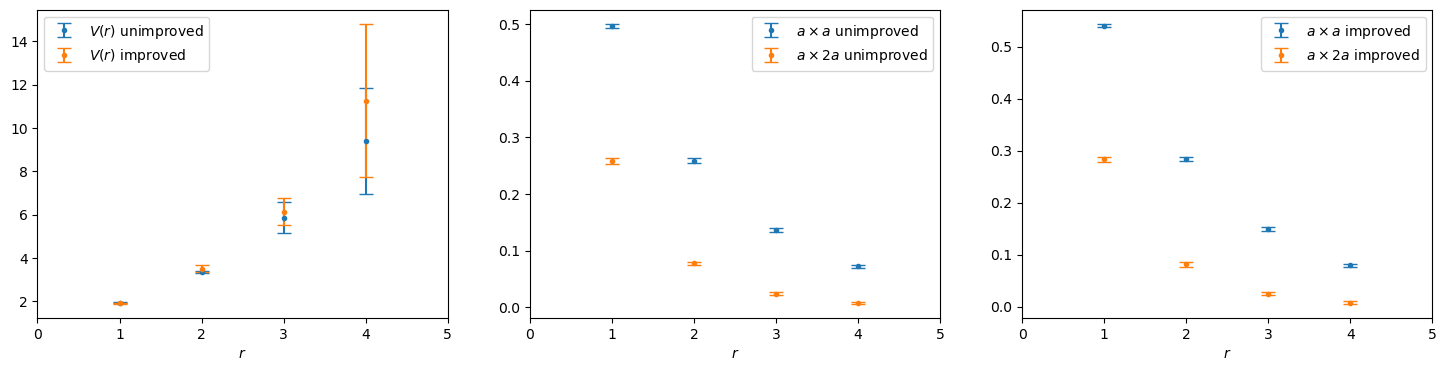

In [177]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
radius = np.arange(1, 5, 1)

axes[0].errorbar(radius, ori_mean_std[:,0], ori_mean_std[:,1], fmt = '.', capsize=5, label = r'$V(r)$ unimproved')
axes[0].errorbar(radius, imp_mean_std[:,0], imp_mean_std[:,1], fmt = '.', capsize=5, label = r'$V(r)$ improved')
axes[1].errorbar(radius, ones_ori.mean(axis=0)[::-1], ones_ori.std(axis=0)[::-1], fmt = '.', capsize=5, label = r'$a\times  a$ unimproved')
axes[1].errorbar(radius, twos_ori.mean(axis=0)[::-1], twos_ori.std(axis=0)[::-1], fmt = '.', capsize=5, label = r'$a\times 2a$ unimproved')
axes[2].errorbar(radius, ones_imp.mean(axis=0)[::-1], ones_imp.std(axis=0)[::-1], fmt = '.', capsize=5, label = r'$a\times  a$ improved')
axes[2].errorbar(radius, twos_imp.mean(axis=0)[::-1], twos_imp.std(axis=0)[::-1], fmt = '.', capsize=5, label = r'$a\times 2a$ improved')

for axis in axes:
    standard_plot(axis)

The plots above show the value of static quark potential and Wilson loops as function of $r$. For some reason (will be investigated again), the errors in improved action are unexpectedly bigger. However, the evolution of both the potential and Wilson loops are still within expectation.